# Assignment 4

Follow the instructions and fill the required parts of this notebook. Provide comments for clarification of your code when necessary. Points will be deducted if we have a hard time reading your
solutions or understanding the structure of your code and results.
Note, you do **not** need to submit a separate report in pdf format. Complete this notebook and submit it. This assignment should be done individually. 

# Introduction
In this homework you implement two unsupervised methods, k-means and EM for Guassian mixtures, for data clustering. In the follwoing, $N$ denotes the number of data points, $K$ is the predefined number of clusters, $D$ is the dimension of each data point, $\textbf{x}_i \in \mathcal{R}^D$ denotes a single data point where $\textbf{x}_i \sim p(\textbf{x}|z=k), k=1,..., K$ denotes the data generating distribution and $p(z=k)$ is the prior on the $k^{th}$ cluster.

## Part 1. Generating the data

First, we generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = \mathcal{N}(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      10.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
Since you generated the data, you already know which sample comes from which class (here cluster).

In [600]:
# Cell 1
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [601]:
# Cell 2: Run this cell to generate the data
num_samples = 400
#I discuss this later, but here I briefly toyed with num_samples = 10000 to get a more accurate picture of things
cov = np.array([[10., 7], [7, 10.]]) * 1
mean_1 = [.1, .1]
mean_2 = [.1, 10]

x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples // 2)
x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples // 2)
xy_class1 = np.column_stack((x_class1, np.zeros(num_samples // 2)))
xy_class2 = np.column_stack((x_class2, np.ones(num_samples // 2)))
data_full = np.row_stack([xy_class1, xy_class2])
np.random.shuffle(data_full)
data = data_full[:, :2]
labels = data_full[:, 2]

Now, we make a scatter plot of the data points showing the true cluster assignment of each point
using different colors and shapes.

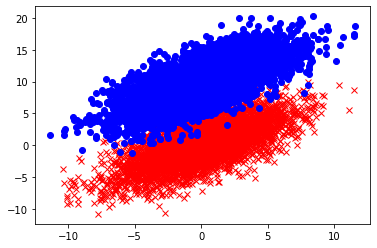

In [602]:
# Cell 3: Run this cell to make scatter plot of the data points showing the true cluster assignment
plt.plot(data[labels==0, 0], data[labels==0, 1], 'xr'); # first class, x shape
plt.plot(data[labels==1, 0], data[labels==1, 1], 'ob'); # second class, circle shape


## Part 2. Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm to cluster the data points.
  To this end we need to write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means). You may initialize the algorithm with
  $$
    \hat\mu_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat\mu_2=
    \begin{bmatrix}
      1.0 \\
      6.0
    \end{bmatrix}
  $$
  and run it until convergence. 

Fill the below Cells 5 and 6 to complete the two needed functions `km_assignment_step`, and `km_refitting_step`. The required function to calculate cost J is provided in Cell 4.

In [603]:
# Cell 4 (To Do): Run this cell for Cost function J
def cost(data, R, Mu):
    N, D = data.shape
    K = Mu.shape[1]
    J = 0
    for k in range(K):
        J += np.dot(np.linalg.norm(data - np.array([Mu[:, k], ] * N), axis=1)**2, R[:, k])
    return J

In [604]:
# Cell 5 (To Do): K-Means Assignment Step
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        R_new: a NxK matrix of responsibilities. Each row of the matrix contains K elements, one of which should be 1
        and the rest should be zero. This will mean that this particular point 
        belongs to one and only one cluster.
    """
    
    N, D = data.shape #Number of datapoints and dimension of datapoint
    K = Mu.shape[1] # number of clusters
    r = np.zeros((N, K)) 
    for k in range(K):
        r[:, k] = np.sum((data-Mu[:, k])**2,axis=1)
    # Fill this in:
    
    # arg_min = ... # argmin along dimension 1
    arg_min = np.argmin(r,1)
    
    # R_new = ... # Set to zeros with shape (N, K)
    R_new = np.zeros((N, K))
    
    # R_new[..., ...] = 1 # Assign the proper element in each row to 1
    for i in range(N):
        R_new[i, arg_min[i]] = 1
        
    return R_new

In [605]:
# Cell 6 (To Do): K-means Refitting Step
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.
    
    Args:
        data: a NxD matrix for the data points
        R: a NxK matrix of responsibilities. Each row of the matrix contains K elements, one of which should be 1
        and the rest should be zero. This will mean that this particular point 
        belongs to one and only one cluster.
        Mu: a DxK matrix for the cluster means locations
    
    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """
    N, D = data.shape # Number of datapoints and dimension of datapoint
    K = R.shape[1] # number of clusters

    Mu_new = np.zeros((D, K))
    for i in range(K):
      # Fill this in:
      # Mu_new = ...
        Mu_new[i] = np.matmul(data.T, R[:,i])/np.sum(R[:, i])
        
    return Mu_new


Run Cell 7 to call the k-means algorithm and apply it to the data ponts. You may play with the `max_iter` and initilil values of `Mu` to see their effect.


In [606]:
# Cell 7: Run this cell to call the K-means algorithm
N, D = data.shape
K = 2
max_iter = 100
class_init = np.random.binomial(1., .5, size=N)
R = np.vstack([class_init, 1 - class_init]).T

Mu = np.zeros([D, K])
Mu[:, 1] = 1.

R.T.dot(data), np.sum(R, axis=0)

#Modified slightly to save costs for graphing later
#Also, changing var names so that km predictions are saved in different variables from Gaussian EM predictions
km_costs = []

for it in range(max_iter):
    R = km_assignment_step(data, Mu)
    Mu = km_refitting_step(data, R, Mu)
    x = cost(data, R, Mu)
    km_costs.append(x)
    print(it, x)

km_class_1 = np.where(R[:, 0])
km_class_2 = np.where(R[:, 1])

0 297535.24861873663
1 191605.02856529772
2 181434.1287391986
3 180971.63867460797
4 180891.61594975943
5 180883.20582626716
6 180883.20582626716
7 180883.20582626716
8 180883.20582626716
9 180883.20582626716
10 180883.20582626716
11 180883.20582626716
12 180883.20582626716
13 180883.20582626716
14 180883.20582626716
15 180883.20582626716
16 180883.20582626716
17 180883.20582626716
18 180883.20582626716
19 180883.20582626716
20 180883.20582626716
21 180883.20582626716
22 180883.20582626716
23 180883.20582626716
24 180883.20582626716
25 180883.20582626716
26 180883.20582626716
27 180883.20582626716
28 180883.20582626716
29 180883.20582626716
30 180883.20582626716
31 180883.20582626716
32 180883.20582626716
33 180883.20582626716
34 180883.20582626716
35 180883.20582626716
36 180883.20582626716
37 180883.20582626716
38 180883.20582626716
39 180883.20582626716
40 180883.20582626716
41 180883.20582626716
42 180883.20582626716
43 180883.20582626716
44 180883.20582626716
45 180883.20582626716

Now, show the resulting cluster assignments on a scatter plot by running Cell 8.

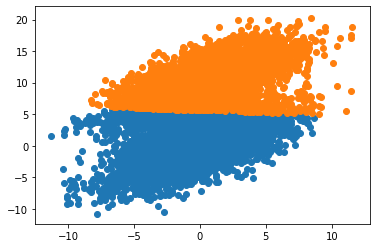

In [607]:
# Cell 8: Run to make a scatterplot for the data points showing the K-Means cluster assignments of each point
plt.scatter(data[km_class_1,0], data[km_class_1,1]) # first class, x shape
plt.scatter(data[km_class_2,0], data[km_class_2,1]) # first class, x shape
plt.show()

## Part 3. Implement EM algorithm for Gaussian mixtures
In this part we implement the EM algorithm for Gaussian mixtures.
  Three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` are needed towards this goal (see lectures slides).
  We initialize the algorithm with means as in Part 2, covariances with $\hat\Sigma_1=\hat\Sigma_2=I$,
  and $\hat\pi_1=\hat\pi_2$. We use the formulas provided in lecture slides, e.g. we update covvariance matrix $\Sigma_k$ with the follwoing equation:

$$\hat{\mathbf{\Sigma}_k} = \frac{1}{N_k} \sum^N_{n=1} r_k^{(n)}(\mathbf{x}^{(n)} - \hat{\mathbf{\mu}_k})(\mathbf{x}^{(n)} - \hat{\mathbf{\mu}_k})^{\top}$$
    
We Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot. 

Run Cells 9 and 10 to generate functions `normal_density` and `log_likelihood`. Fill Cell 11 and 12 to create `gm_e_step`, and `gm_m_step`.

In [608]:
 # Cell 9:
 def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

In [609]:
# Cell 10: EM LogLikelihood
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.
    
    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """
    N, D = Mu.shape
    K = len(Sigma)
    L, T = 0., 0.
    for n in range(N):
        for k in range(K):
            T += normal_density(data[n, :], Mu[:, k], Sigma[k]) * Pi[k]; # Compute the likelihood from the k-th Gaussian weighted by the mixing coefficients 
        L += np.log(T)
    return L

In [610]:
# Cell 11 (To Do): Gaussian Mixture Expectation Step
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: a NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    
    Returns:
        Gamma: a NxK matrix of responsibilities 
    """
    
    N, D = data.shape
    K = len(Sigma)
    Gamma = np.zeros((N, K))    
    for n in range(N):
        for k in range(K):
          # Fill this in:
        
          # Gamma[n, k] =...
            Gamma[n, k] = Pi[k] * normal_density(data[n], Mu[:, k], Sigma[k])
            
        # Gamma[n, :]=... # Normalize by sum across second dimension (mixtures
        Gamma[n, :] /= (Gamma[n, 0] + Gamma[n, 1])
    return Gamma

In [611]:
# Cell 12 (To Do): Gaussian Mixture Maximization Step
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: a NxD matrix for the data points
        Gamma: a NxK matrix of responsibilities 
    
    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """
    
    N, D = data.shape
    N, K = Gamma.shape
    Nk = np.sum(Gamma, axis=0) # Sum along first axis 
    # Fill this in:
    # Mu = ...  
    Mu = np.matmul(np.transpose(data), Gamma)
    Mu = np.column_stack([np.transpose(Mu[:, 0] / float(Nk[0])), np.transpose(Mu[:, 1] / float(Nk[1]))])
    
    Sigma = [0]*K
    for k in range(K):
        for n in range(N):
            p = np.reshape(data[n, :] - Mu[:, k], (D, 1)) 
            Sigma[k] += (1/Nk[k])*Gamma[n, k] * p.dot(p.T)
    # Fill this in:
    # Pi=...
    Pi = Nk/N
    return Mu, Sigma, Pi


Run Cell 13 to call the Gaussian mixture EM algorithm and apply it to the data ponts. You may play with the `max_iter` and initilil values associated to `Mu`, `Sigma` and `Pi` to see their effect.


In [612]:
# Cell 13: Run this cell to call the Gaussian Mixture EM algorithm
N, D = data.shape
K = 2

Mu = np.zeros((D,K))
Mu[:, 1] = 1
Sigma = [np.eye(2), np.eye(2)]
Pi = np.ones(K) / K

Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities 

max_iter  = 100

#Modified this to save values for plotting

gauss_costs = []

for it in range(max_iter):
    Gamma = gm_e_step(data, Mu, Sigma, Pi)
    Mu, Sigma, Pi = gm_m_step(data, Gamma)
    x = log_likelihood(data, Mu, Sigma, Pi)
    gauss_costs.append(x)
    print(it, x) 

0 -8.89496087802441
1 -8.96563031090444
2 -8.999017341299677
3 -9.033417451934604
4 -9.07237553433859
5 -9.099998079928557
6 -9.11552527757936
7 -9.131547890518725
8 -9.163148047499401
9 -9.218794770483203
10 -9.297237845065808
11 -9.383502928203502
12 -9.457923955059389
13 -9.511746252167814
14 -9.547073957622572
15 -9.56926841851433
16 -9.582967762646838
17 -9.591366528250663
18 -9.596502456218227
19 -9.599640050927642
20 -9.601556105059636
21 -9.602726010590194
22 -9.603440284726732
23 -9.603876364654646
24 -9.60414259717898
25 -9.604305134471552
26 -9.604404364539343
27 -9.604464945010225
28 -9.604501929657555
29 -9.604524508933604
30 -9.604538293666854
31 -9.604546709296422
32 -9.60455184706794
33 -9.604554983695362
34 -9.604556898617155
35 -9.604558067683474
36 -9.604558781402439
37 -9.604559217130255
38 -9.604559483143618
39 -9.604559645545681
40 -9.604559744692668
41 -9.604559805222237
42 -9.604559842175696
43 -9.604559864735975
44 -9.60455987850909
45 -9.60455988691764
46 -9.6

Now, show the resulting cluster assignments on a scatter plot by running Cell 14.

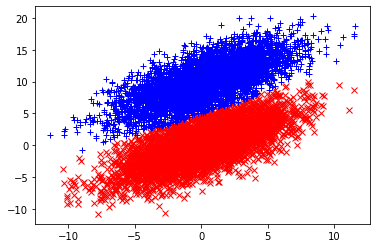

In [613]:
# Cell 14: Run to make a scatterplot for the data points showing the EM cluster assignments of each point
class_1 = np.where(Gamma[:, 0] >= .5)
class_2 = np.where(Gamma[:, 1] > .5)
plt.plot(data[class_1, 0], data[class_1, 1], 'xr'); # first class, x shape
plt.plot(data[class_2, 0], data[class_2, 1], '+b'); # second class, circle shape

## Part 4 (To Do). Comment on findings + additional experiments 

* Plot k-means cost vs. the number of iterations.
* What is k-means misclassification error? Hint: you generated the data, you know the correct labels. Your unsupervised learning algorithm doesn’t.
* Plot log-likelihood vs. the number of iterations for the EM method.
* What is the EM misclassification error?
* Compare the performance of k-Means and EM based on the resulting cluster assignments. 
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for each method? 



**To Do: Provide your answers here**


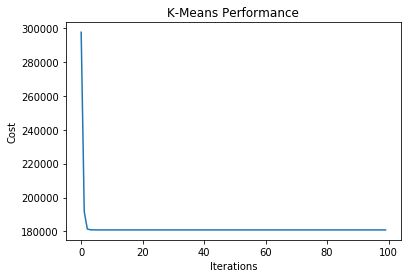

In [614]:
#k-means cost vs. the number of iterations
max_iter = 100

plt.clf()
plt.plot(range(max_iter), km_costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("K-Means Performance")
plt.show()

In [615]:
acc = 0
for pred in data[km_class_1]:
    if (pred in data[labels==0]):
       acc += 1

for pred in data[km_class_2]:
    if (pred in data[labels==1]):
       acc += 1
print("K-Means misclassification error:", 1 - acc/num_samples)

K-Means misclassification error: 0.06989999999999996


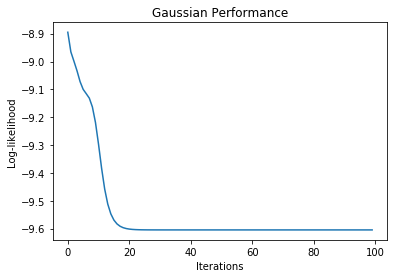

In [616]:
#log-likelihood vs. the number of iterations for the EM method
max_iter = 100

plt.clf()
plt.plot(range(max_iter), gauss_costs)
plt.xlabel("Iterations")
plt.ylabel("Log-likelihood")
plt.title("Gaussian Performance")
plt.show()

In [617]:
acc = 0
for pred in data[class_1]:
    if (pred in data[labels==0]):
       acc += 1

for pred in data[class_2]:
    if (pred in data[labels==1]):
       acc += 1
print("Gaussian EM misclassification error:", 1 - acc/num_samples)

Gaussian EM misclassification error: 0.01529999999999998


## Cluster Assignments
K-means and Gaussian EM both have a respectable performance on this dataset. Over 10 runs, I never observed Gaussian EM having an accuracy below 90%, and K-means only failed to meet that threshold once. However, Gaussian EM consistently outperformed its counterpart. On average, K-means had an error rate around 8%, and Gaussian EM had an error rate of approximately 1%. The Gaussian method is the clear winner.

I didn't notice it at the base value of 400 samples, but when I increased it to 10000, I could see a visual distinction between the two approaches. K-means perceives there to be a horizontal divider between the two samples, whereas Gaussian EM is able to correctly deduce that the separator is closer to a diagonal.

## Convergence
Over several runs, K-means typically converges before its 5th iteration, while Gaussian EM converges around or slightly after its 20th iteration. The bottleneck of the two methods (or indeed, any machine learning algorithm) will be the step that performs the greatest number of matrix multiplications: the refitting step in K-means, and the Gaussian mixture maximization step. However, with the extremely small set of 400 samples we're using, neither method takes very long at all to finish executing.